# A Spark notebook to detect clickbait news titles


## Introduction
The Oxford English dictionary defines clickbait as “on the internet, content whose main purpose is to attract attention and encourage visitors to click on a link to a particular web page”. Informally, clickbait headlines are those which satisfy two main criteria:

    They exploit the so-called “curiosity gap” by not explaining the full article contents
    They provide misleading information about the article contents

In other words, these headlines contain text which leaves the reader curious about what the article contents might be, or they contain text about topics not really covered in the article itself. Examples of clickbait headline include things like

    I left my husband and daughter home alone, and you’ll never believe what happened!
    19 Tweets anyone addicted to diet coke will totally relate to
    What these pilots do with dogs is the most brilliant thing I’ve ever seen
    She picks this object off the ground, but watch what happens when it starts to move!

Since clickbait is becomming increasingly common, and is genereally considered a nuisance to internet users, let’s see if we can use machine learning and natural language processing to identify these headlines automatically. 

[Chakraborty et al.](http://cse.iitkgp.ac.in/~abhijnan/papers/chakraborty_clickbait_asonam16.pdf) performed a study on clickbait headlines and is covered in [this informative article](https://www.linkedin.com/pulse/identifying-clickbaits-using-machine-learning-abhishek-thakur).

We will use the the dataset from Chakraborty et al. study which is publicly available, and can be found [here](https://github.com/bhargaviparanjape/clickbait/tree/master/dataset). 

The data contain 16,000 clickbait headlines from BuzzFeed, Upworthy, ViralNova, Thatscoop, Scoopwhoop and ViralStories, along with 16,000 non-clickbait headlines from WikiNews, New York Times, The Guardian, and The Hindu. Let’s import some useful Python libraries, and read in the dataset.

## Environment setup

In [2]:
import os

memory = '8g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args
#spark.sparkContext._conf.getAll()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('clickbait').getOrCreate()

In [4]:
spark.sparkContext._conf.getAll()

[('spark.app.name', 'clickbait'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.memory', '8g'),
 ('spark.driver.port', '36413'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1521970921964'),
 ('spark.driver.host', '192.168.1.17')]

In [5]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, Tokenizer,StopWordsRemover, CountVectorizer,IDF,StringIndexer
from pyspark.ml import Pipeline
from string import punctuation
from pyspark.sql.functions import lit, Column, length, col, count, corr, udf
import pyspark.ml.feature as features
import pyspark.sql.types as types
from pyspark.mllib.stat import Statistics 
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import re

In [35]:
import pandas as pd

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from IPython.display import display, HTML, display_html #usefull to display wide tables

## Read the data

In [7]:
cb = spark.read.text("data/clickbait_data")\
.filter("value != ''")\
.withColumnRenamed('value','headline')\
.withColumn('label', lit(1))

In [8]:
cb.head(3)

[Row(headline='Should I Get Bings', label=1),
 Row(headline='Which TV Female Friend Group Do You Belong In', label=1),
 Row(headline='The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills', label=1)]

In [9]:
ncb = spark.read.text("data/non_clickbait_data")\
.filter("value != ''").withColumnRenamed('value','headline').withColumn('label', lit(0))

In [10]:
ncb.head(3)

[Row(headline='Bill Changing Credit Card Rules Is Sent to Obama With Gun Measure Included', label=0),
 Row(headline='In Hollywood, the Easy-Money Generation Toughens Up', label=0),
 Row(headline="1700 runners still unaccounted for in UK's Lake District following flood", label=0)]

In [11]:
data = cb.union(ncb)

In [12]:
data.printSchema()

root
 |-- headline: string (nullable = true)
 |-- label: integer (nullable = false)



In [13]:
data.cache()

DataFrame[headline: string, label: int]

In [14]:
# click bait Vs non click-bait counts 
data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|15999|
|    0|16001|
+-----+-----+



## Feature Engineering

To build a classifier we need a little more than just the headline tex. So in this section I will following new features:

    Number of words in the headline
    Number of stop words in the headline
    Number of contractions in the headline
    Frequency of various parts of speech in the headline
    Is the headline a question?
    Ratio of stop words to total number of words
    Ratio of contractions to total number of words

Following functions will be used to build new features

## Invalid chars

In [15]:
def process_text(text):
    result = text.replace('/', '').replace('\n', '')
    result = re.sub(r'[1-9]+', 'number', result)
    result = re.sub(r'(\w)(\1{2,})', r'\1', result)
    result = re.sub(r'(?x)\b(?=\w*\d)\w+\s*', '', result)
    result = ''.join(t for t in result if t not in punctuation)
    result = re.sub(r' +', ' ', result).lower().strip()
    return result

process_text_udf = udf(process_text, types.StringType())

## count stop words

In [16]:
sw_df = spark.read.text("data/english_stopwords.txt")
stop_words = [val["value"] for val in sw_df.toLocalIterator()]

In [17]:
def count_stop_words(text):
    s = text.split()
    num = len([word for word in s if word in stop_words])
    return num

count_stop_words_udf = udf(count_stop_words, types.IntegerType())

## questions and contarctions

In [18]:
question_words = ['who', 'whos', 'whose', 'what', 'whats', 'whatre', 'when', 'whenre', 'whens', 'couldnt',
        'where', 'wheres', 'whered', 'why', 'whys', 'can', 'cant', 'could', 'will', 'would', 'is',
        'isnt', 'should', 'shouldnt', 'you', 'your', 'youre', 'youll', 'youd', 'here', 'heres',
        'how', 'hows', 'howd', 'this', 'are', 'arent', 'which', 'does', 'doesnt']

contractions = ['tis', 'aint', 'amnt', 'arent', 'cant', 'couldve', 'couldnt', 'couldntve',
                'didnt', 'doesnt', 'dont', 'gonna', 'gotta', 'hadnt', 'hadntve', 'hasnt',
                'havent', 'hed', 'hednt', 'hedve', 'hell', 'hes', 'hesnt', 'howd', 'howll',
                'hows', 'id', 'idnt', 'idntve', 'idve', 'ill', 'im', 'ive', 'ivent', 'isnt',
                'itd', 'itdnt', 'itdntve', 'itdve', 'itll', 'its', 'itsnt', 'mightnt',
                'mightve', 'mustnt', 'mustntve', 'mustve', 'neednt', 'oclock', 'ol', 'oughtnt',
                'shant', 'shed', 'shednt', 'shedntve', 'shedve', 'shell', 'shes', 'shouldve',
                'shouldnt', 'shouldntve', 'somebodydve', 'somebodydntve', 'somebodys',
                'someoned', 'someonednt', 'someonedntve', 'someonedve', 'someonell', 'someones',
                'somethingd', 'somethingdnt', 'somethingdntve', 'somethingdve', 'somethingll',
                'somethings', 'thatll', 'thats', 'thatd', 'thered', 'therednt', 'theredntve',
                'theredve', 'therere', 'theres', 'theyd', 'theydnt', 'theydntve', 'theydve',
                'theydvent', 'theyll', 'theyontve', 'theyre', 'theyve', 'theyvent', 'wasnt',
                'wed', 'wedve', 'wednt', 'wedntve', 'well', 'wontve', 'were', 'weve', 'werent',
                'whatd', 'whatll', 'whatre', 'whats', 'whatve', 'whens', 'whered', 'wheres',
                'whereve', 'whod', 'whodve', 'wholl', 'whore', 'whos', 'whove', 'whyd', 'whyre',
                'whys', 'wont', 'wontve', 'wouldve', 'wouldnt', 'wouldntve', 'yall', 'yalldve',
                'yalldntve', 'yallll', 'yallont', 'yallllve', 'yallre', 'yallllvent', 'yaint',
                'youd', 'youdve', 'youll', 'youre', 'yourent', 'youve', 'youvent']

In [19]:
def num_contractions(text):
    s = text.split()
    num = len([word for word in s if word in contractions])
    return num

count_contractions_udf = udf(num_contractions, types.IntegerType())
#-------------------------------------------------------------------
def start_with_question_word(text):
    s = text.split()
    if s[0] in question_words:
        return 1
    else:
        return 0
    
start_with_question_word_udf = udf(start_with_question_word, types.IntegerType())  
#-------------------------------------------------------------------
def part_of_speech(text):
    import nltk
    s = text.split()
    nonstop = [word for word in s if word not in stop_words]
    pos = [part[1] for part in nltk.pos_tag(nonstop)]
    pos = ' '.join(pos)
    return pos
pos_tag_udf = udf(part_of_speech, types.StringType())

## apply text processing

In [20]:
data_cleaned = data.withColumn("cleaned", process_text_udf(data['headline']))\
                   .withColumn('length',length('cleaned'))\
                   .withColumn("num_stop_words",      count_stop_words_udf("cleaned"))\
                   .withColumn("num_contractions",    count_contractions_udf("cleaned"))\
                   .withColumn("start_with_question",  start_with_question_word_udf("cleaned"))\
                   .withColumn("pos_tags",  pos_tag_udf("cleaned"))

In [21]:
data_cleaned.show()

+--------------------+-----+--------------------+------+--------------+----------------+-------------------+--------------------+
|            headline|label|             cleaned|length|num_stop_words|num_contractions|start_with_question|            pos_tags|
+--------------------+-----+--------------------+------+--------------+----------------+-------------------+--------------------+
|  Should I Get Bings|    1|  should i get bings|    18|             2|               0|                  1|              VB NNS|
|Which TV Female F...|    1|which tv female f...|    45|             4|               0|                  1|     NN NN NN NN VBD|
|The New "Star War...|    1|the new star wars...|    70|             6|               0|                  0|JJ NN NNS VBP NNS...|
|This Vine Of New ...|    1|this vine of new ...|    65|             4|               0|                  1|JJ JJ NN NN JJ NN...|
|A Couple Did A St...|    1|a couple did a st...|   100|             9|               0|  

In [22]:
# create ration columns
data_cleaned2 = data_cleaned.withColumn("stop_word_ratio", data_cleaned["num_stop_words"]/data_cleaned["length"])\
                            .withColumn("contraction_ratio", data_cleaned["num_contractions"]/data_cleaned["length"]) 

In [23]:
data_cleaned2.select("stop_word_ratio","contraction_ratio","pos_tags").show(truncate=False)

+--------------------+--------------------+--------------------------------------+
|stop_word_ratio     |contraction_ratio   |pos_tags                              |
+--------------------+--------------------+--------------------------------------+
|0.1111111111111111  |0.0                 |VB NNS                                |
|0.08888888888888889 |0.0                 |NN NN NN NN VBD                       |
|0.08571428571428572 |0.0                 |JJ NN NNS VBP NNS VBP JJ NNS          |
|0.06153846153846154 |0.0                 |JJ JJ NN NN JJ NN NN NN               |
|0.09                |0.0                 |NN VBG NN NN NN VBG JJ NN NN          |
|0.08695652173913043 |0.0                 |NN NN NNS IN VBG JJ NN                |
|0.04918032786885246 |0.0                 |NN JJ NNS JJ RB VBG                   |
|0.07894736842105263 |0.02631578947368421 |NN NNS VBP                            |
|0.06896551724137931 |0.017241379310344827|NNS VBP JJ RBS JJ NN                  |
|0.0

In [24]:
data_cleaned2.cache()

DataFrame[headline: string, label: int, cleaned: string, length: int, num_stop_words: int, num_contractions: int, start_with_question: int, pos_tags: string, stop_word_ratio: double, contraction_ratio: double]

## lets explore some columns

In [25]:
data_cleaned2.printSchema()

root
 |-- headline: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- cleaned: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- num_stop_words: integer (nullable = true)
 |-- num_contractions: integer (nullable = true)
 |-- start_with_question: integer (nullable = true)
 |-- pos_tags: string (nullable = true)
 |-- stop_word_ratio: double (nullable = true)
 |-- contraction_ratio: double (nullable = true)



### Headline starts with question

Text(0,0.5,'Number of Headlines')

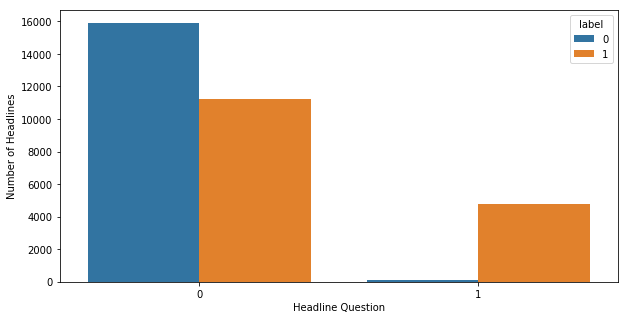

In [26]:
question_df = data_cleaned2.groupBy('label', 'start_with_question').count().toPandas()

figure, axes = plt.subplots(figsize=(10,5))
plot = sns.barplot(x="start_with_question", y="count", hue="label" , data=question_df)
plot.set_xlabel('Headline Question')
plot.set_ylabel('Number of Headlines')

It seems that clickbait headlines are more likely start with a question.

### Number of words

Text(0,0.5,'Number of Headlines')

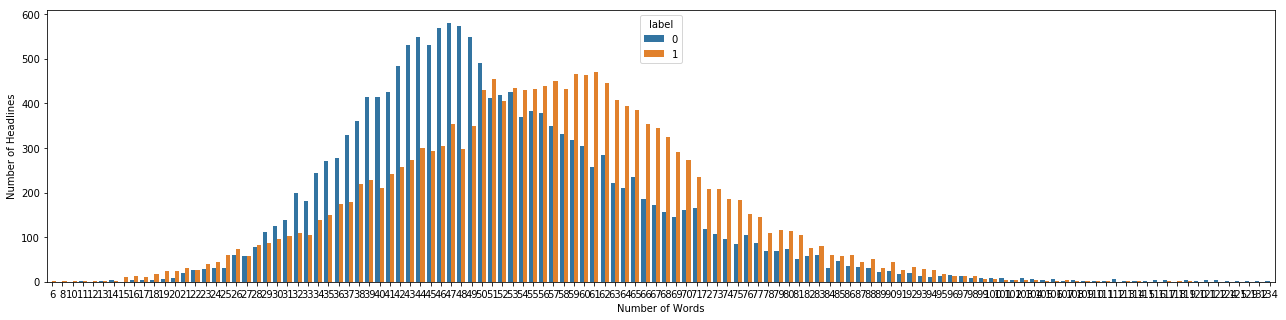

In [27]:
length_pdf = data_cleaned2.groupBy('label', 'length').count().toPandas()

figure, axes = plt.subplots(figsize=(22,5))
plot = sns.barplot(x="length", y="count", hue="label" , data=length_pdf)
plot.set_xlabel('Number of Words')
plot.set_ylabel('Number of Headlines')

### Number of stop words

Text(0,0.5,'Number of Headlines')

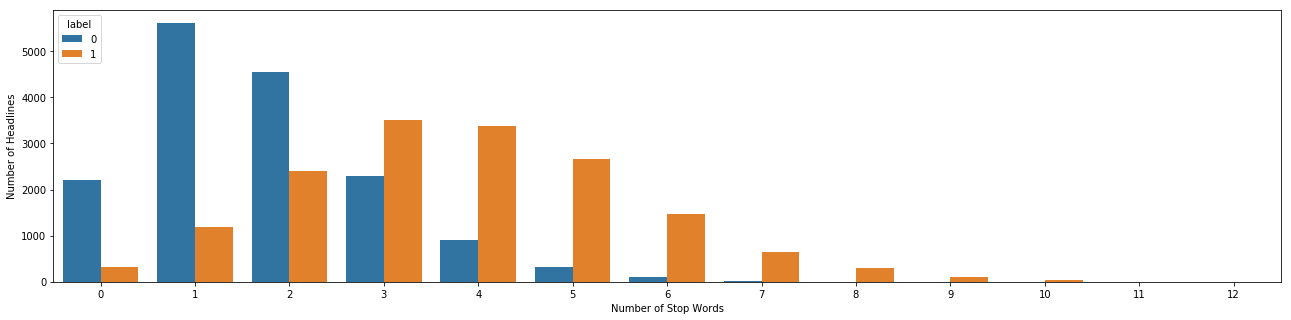

In [28]:
sw_pdf = data_cleaned2.groupBy('label', 'num_stop_words').count().toPandas()

figure, axes = plt.subplots(figsize=(22,5))
plot = sns.barplot(x="num_stop_words", y="count", hue="label" , data=sw_pdf)
plot.set_xlabel('Number of Stop Words')
plot.set_ylabel('Number of Headlines')

### Number of contractions

Text(0,0.5,'Number of Headlines')

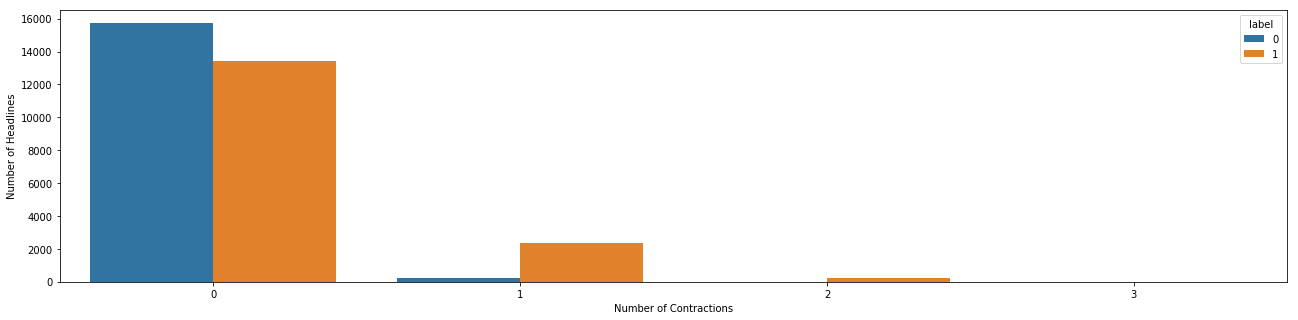

In [30]:
cont_pdf = data_cleaned2.groupBy('label', 'num_contractions').count().toPandas()
figure, axes = plt.subplots(figsize=(22,5))
plot = sns.barplot(x="num_contractions", y="count", hue="label" , data=cont_pdf)
plot.set_xlabel('Number of Contractions')
plot.set_ylabel('Number of Headlines')

###  numerical data correlation

In [31]:
features = data_cleaned2.select("length", "num_stop_words", "num_contractions", 
                                "stop_word_ratio","contraction_ratio").rdd.map(lambda row: row[0:])
#corr_mat=Statistics.corr(features, method="pearson")
#Statistics.corr(data_cleaned2, method="pearson")

In [32]:
corr_mat=Statistics.corr(features, method="pearson")

In [38]:
index = columns = ["length", "num_stop_words", "num_contractions", "stop_word_ratio","contraction_ratio"]
corr_pdf = pd.DataFrame(corr_mat,index=index, columns=columns)

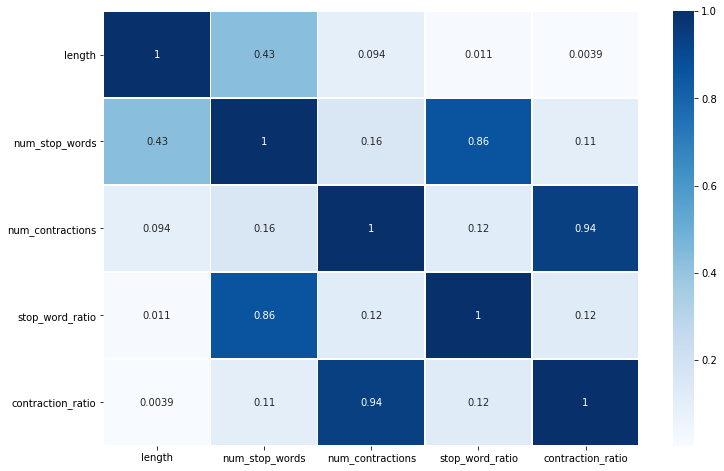

In [40]:
#https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap
figure, axes = plt.subplots(figsize=(12,8))
sns.heatmap(corr_pdf, annot=True, vmax=1, linewidths=.5, cmap='Blues')

It seems that the following are correlated 

    > num_stop_words and stop_word_ratio
    > num_contractions and contraction_ratio
    > length and num_stop_words (small)

This collinearity could impact accuracy of our classifier, so lets drop num_stop_words and num_contractions from our dataset.

In [41]:
data_cleaned3 = data_cleaned2.drop("drop num_stop_words", "num_contractions")

In [43]:
data_cleaned3.cache()

DataFrame[headline: string, label: int, cleaned: string, length: int, num_stop_words: int, start_with_question: int, pos_tags: string, stop_word_ratio: double, contraction_ratio: double]

## Create feature vector

In [44]:
# stages of pipeline
tokenizer = Tokenizer(inputCol="cleaned", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")


pos_tokenizer = Tokenizer(inputCol="pos_tags", outputCol="pos_token_text")
pos_count_vec = CountVectorizer(inputCol='pos_token_text',outputCol='pos_c_vec')

make_featur_vector = VectorAssembler(inputCols=['tf_idf','length', 'num_stop_words', 'start_with_question', 'pos_c_vec', 
                                      'stop_word_ratio', 'contraction_ratio'],outputCol='features')
# define the pipeline
data_prep_pipe = Pipeline(stages=[tokenizer,                # get token from headline
                                  stopremove,               # stopword tokens
                                  count_vec,idf,            # idf vectoriser
                                  pos_tokenizer,            # part of speach tokenizer
                                  pos_count_vec,            # part of speach counter
                                  make_featur_vector])      # create a vector of features

# fit the data prep pipe line
cleaner = data_prep_pipe.fit(data_cleaned3)

# transfor the data
clean_data = cleaner.transform(data_cleaned3)

In [45]:
# We only need the feature vector and label
final_data = clean_data.select(['label','features'])

In [46]:
final_data.head()

Row(label=1, features=SparseVector(24116, {20: 4.4846, 17736: 9.6804, 24075: 18.0, 24076: 2.0, 24077: 1.0, 24079: 1.0, 24086: 1.0, 24114: 0.1111}))

In [47]:
del data, data_cleaned, data_cleaned2, data_cleaned3

In [48]:
training, testing = final_data.randomSplit([0.7,0.3])

## Lets just test a NaiveBayes classifier with default settings

In [49]:
# Use defaults
nb = NaiveBayes()

In [50]:
cb_predictor = nb.fit(training)

In [51]:
test_results = cb_predictor.transform(testing)

In [52]:
evaluator = MulticlassClassificationEvaluator(  labelCol="label", predictionCol="prediction")
f1 = evaluator.evaluate(test_results)
print("Test F1 score: {}".format(f1))

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(test_results)
print("Test Accuracy = %g " % (accuracy)) 
print("Test Error = %g " % (1.0 - accuracy))

Test F1 score: 0.9641621756774466
Test Accuracy = 0.964171 
Test Error = 0.0358293 


## Fit  Logistic Regtression model using Grid Search

In [86]:
# https://spark.apache.org/docs/2.2.0/ml-tuning.html
# https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression
# https://spark.apache.org/docs/2.2.0/mllib-linear-methods.html#logistic-regression

In [64]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [104]:
lr = LogisticRegression()
pipeline = Pipeline(stages=[lr])

In [99]:
# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for lr.regParam,
# this grid will only have 3 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01, 0.001])\
                              .addGrid(lr.elasticNetParam,[0,0.1, 0.01, 0.03, 1])\
                              .addGrid(lr.maxIter, [100])\
                              .build()

In [100]:
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)  

In [101]:
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

In [102]:
train_summary = cvModel.bestModel.summary

In [80]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
from ggplot import *

/home/khurram/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/khurram/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


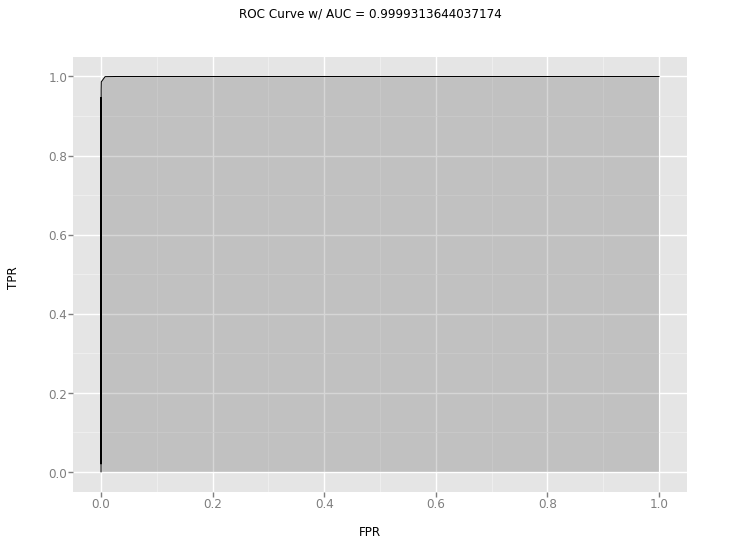

<ggplot: (-9223363264271072035)>

In [103]:
ggplot(train_summary.roc.toPandas(), aes(x = 'FPR', y = 'TPR')) \
+ geom_line(aes(y = 'TPR'))\
+ geom_area(alpha = 0.2) \
+ ggtitle("ROC Curve w/ AUC = %s" % str(train_summary.areaUnderROC)) 

In [92]:
#train_summary.fMeasureByThreshold

DataFrame[threshold: double, F-Measure: double]

## Evaluate of test dataset

In [105]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
cv_prediction = cvModel.transform(testing)

In [106]:
evaluator = MulticlassClassificationEvaluator( labelCol="label", predictionCol="prediction")
f1 = evaluator.evaluate(cv_prediction)
print("Test F1 score: {}".format(f1))

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(cv_prediction)
print("Test Accuracy = %g " % (accuracy)) 
print("Test Error = %g " % (1.0 - accuracy))

Test F1 score: 0.9722665021060501
Test Accuracy = 0.972271 
Test Error = 0.0277287 


In [ ]:
Test F1 score: 0.9687304274588384
Test Accuracy = 0.96874 
Test Error = 0.0312597 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))